[INFO 6154] Project by Team 8 (Joo, Yong Jae)
# Novel Electricity Theft Detection Strategy Based on Dual-Time Feature Fusion and Deep Learning Methods

Time series data analysis to classify abnormal pattern.


Dataset : https://github.com/henryRDlab/ElectricityTheftDetection

[Reference]

1. Huang Q. et al, A Novel Electricity Theft Detection Strategy Based on Dual-Time Feature Fusion and Deep Learning Methods, Energies 2024, 17, 275.
2. Inam Ullah Khan et al, A Stacked Machine and Deep Learning-Based Approach for Analysing Electricity Theft in Smart Grids, IEEE TRANSACTIONS ON SMART GRID, VOL. 13, NO. 2, MARCH 2022.

![Alt text](image-5.png)

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, MultiHeadAttention, LayerNormalization, Dropout, LSTM, Conv1D, GlobalAveragePooling1D, Add, Embedding, Lambda
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

2024-08-03 18:17:59.071297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 18:17:59.170084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 18:17:59.197403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 18:17:59.385870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 18:18:00.971005: W tensorflow/compiler/tf2

In [2]:
# Check if tensorflow is using GPU
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# disable the warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722723484.121551     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723484.362232     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723484.362297     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Load data
df = pd.read_csv("data.csv")

# adjust df to have 2D input 7x147 = 1029
# df = df.iloc[:, :-5]

df

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,13.84,13.50,14.60,14.46,12.34,15.37,17.01,...,21.13,13.75,22.61,18.83,25.52,18.11,19.31,17.48,17.20,15.28


In [4]:
# Extract date columns and sort according to date
date_columns = df.columns.difference(['FLAG', 'CONS_NO'])

sorted_date_columns = sorted(date_columns, key=lambda x: pd.to_datetime(x))

sorted_df = df[['CONS_NO', 'FLAG'] + sorted_date_columns]

sorted_df

,CONS_NO,FLAG,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [5]:
# Check the ratio of 'FLAG' 
# 1: Abnormal(Energy Theft), 0: Normal
print(sorted_df['FLAG'].sum())
print(sorted_df['FLAG'].sum() / df.shape[0])

3615
0.08531577456811101


In [6]:
# Check missing values
print('Number of null values: {} ({}%)'.format(sorted_df.isnull().sum().sum(), 
                                             sorted_df.isnull().sum().sum() / (sorted_df.shape[0] * (sorted_df.shape[1]-1)) * 100 ))

Number of null values: 11233528 (25.615147365113504%)


In [7]:
# Check missing values for every customer (row)
print(sorted_df.isnull().sum(axis=1).sort_values(ascending=False) / df.shape[1])

37830    0.998069
686      0.998069
3028     0.998069
41998    0.998069
419      0.998069
           ...   
601      0.000965
30128    0.000965
30119    0.000965
26965    0.000965
14965    0.000965
Length: 42372, dtype: float64


<Axes: xlabel='ratio of NA', ylabel='number of consumers'>

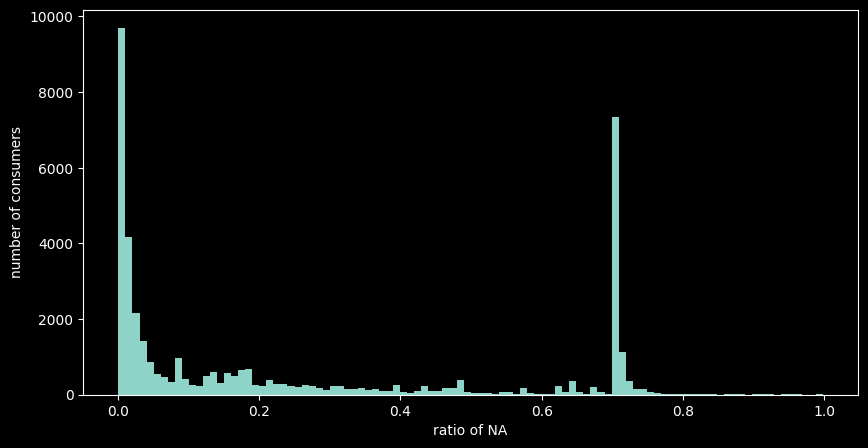

In [8]:
# Display histogram of the number of nulls in each row (across all columns)
na_ratio = sorted_df.isnull().sum(axis=1) / sorted_df.shape[1]
na_ratio.plot(kind='hist', xlabel='ratio of NA', ylabel='number of consumers', bins=100, figsize=(10, 5))


In [9]:
# removing from the original dataset any clients with >600 null values
df = sorted_df[sorted_df.isnull().sum(axis=1) < 600]
print(df.shape)

(31669, 1036)


In [10]:
df

,CONS_NO,FLAG,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [11]:
# removing from the original dataset any clients with >600 null values or 0 values
df = df[(df.isnull().sum(axis=1) + (df == 0).sum(axis=1)) <= 600]


In [12]:
# Check the ratio of 'FLAG'
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

2289
0.08610442371351189


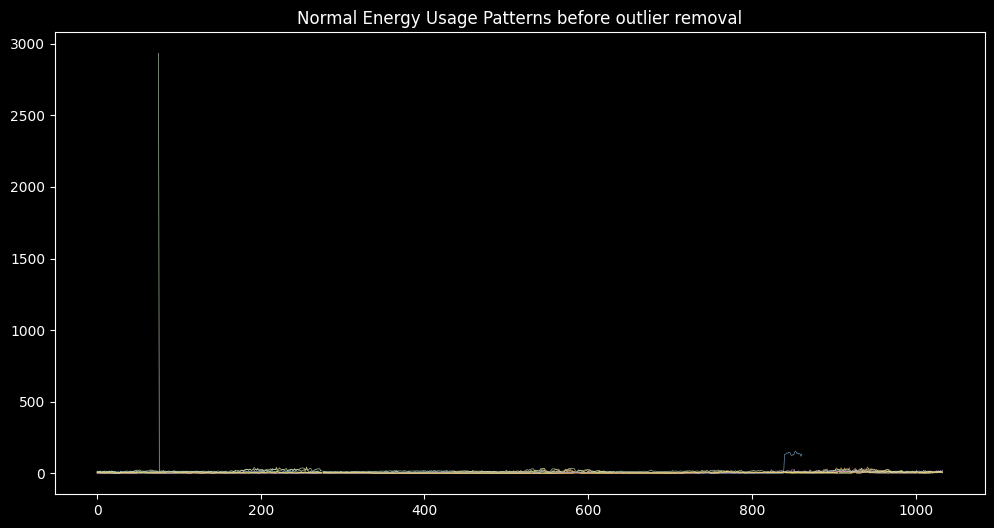

In [13]:
# Display examples of outliers 
plt.grid()

for i in range(220,230):
    plt.plot(range(df.shape[1]-2), df[df['FLAG']==0].iloc[i,2:], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('white') 
plt.gca().patch.set_alpha(0.9)
plt.title("Normal Energy Usage Patterns before outlier removal")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.gca().patch.set_facecolor('black')
plt.show()

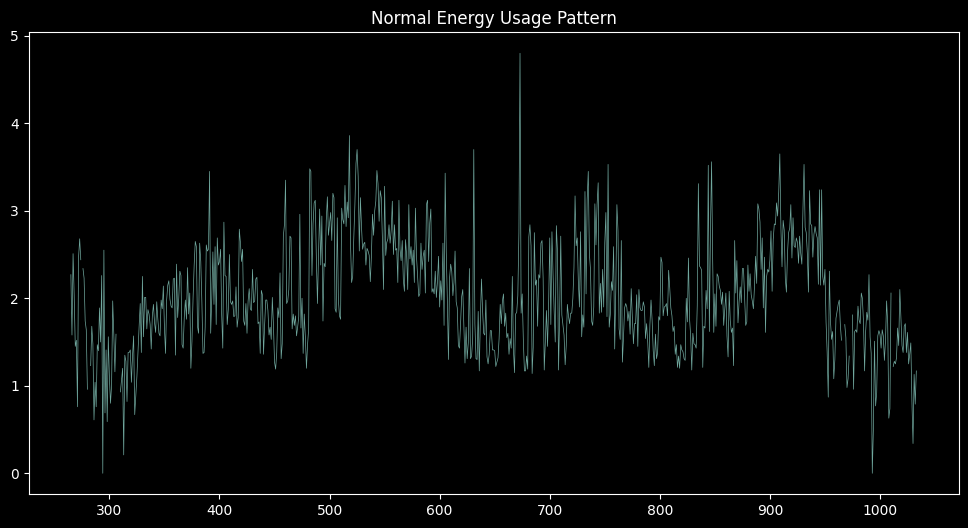

In [14]:
# Display examples of normal energy usage patterns
plt.grid()

for i in range(7, 8):
    plt.plot(range(df.shape[1]-2), df[df['FLAG']==0].iloc[i,2:], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('white') 
plt.gca().patch.set_alpha(0.9)
plt.title("Normal Energy Usage Pattern")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.gca().patch.set_facecolor('black')
plt.show()

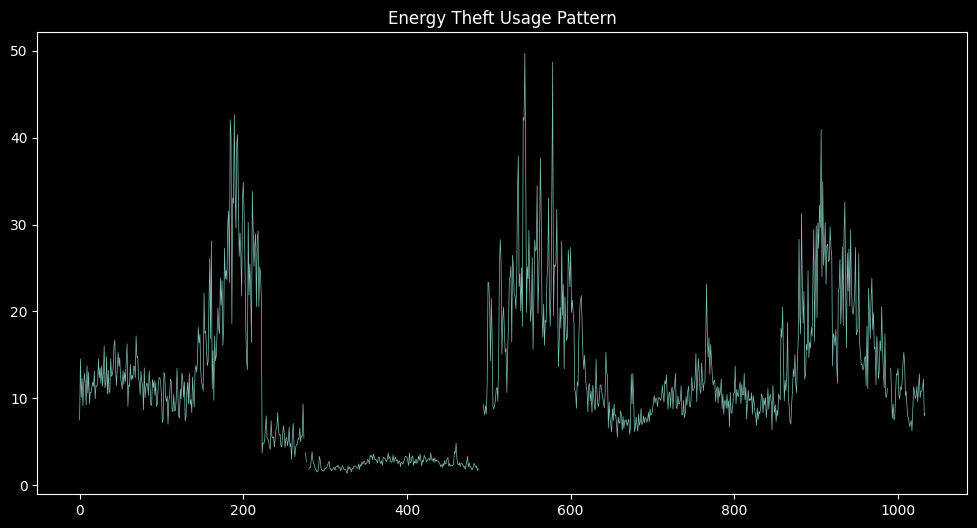

In [15]:
# Display examples of energy theft usage patterns
plt.grid()
for i in range(26,27):
    plt.plot(range(df.shape[1]-2), df[df['FLAG']==1].iloc[i,2:], linewidth=0.5, alpha=0.9)

plt.gca().patch.set_facecolor('white') 
plt.title("Energy Theft Usage Pattern")
plt.gcf().set_size_inches(12,6)
plt.gca().patch.set_facecolor('black')
plt.grid(False)
plt.show()

In [16]:
# Interpolate null values < 7, fill others with 0 according to the paper
df.iloc[:, 2:].interpolate(limit_direction="both", inplace=True, limit=7, axis=1, method='linear')
df.fillna(0, inplace=True)

In [17]:
df

,CONS_NO,FLAG,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,F1472871E1AFF49D4289564B6377D76C,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [18]:
# Handling outliers according to the paper
def handle_outliers(df):
    for col in df.columns[2:]:
        avg = df[col].mean()
        std = df[col].std()
        X = avg + 2*std
        df[col] = df[col].apply(lambda x: X if x > X else x)
    return df

df = handle_outliers(df)


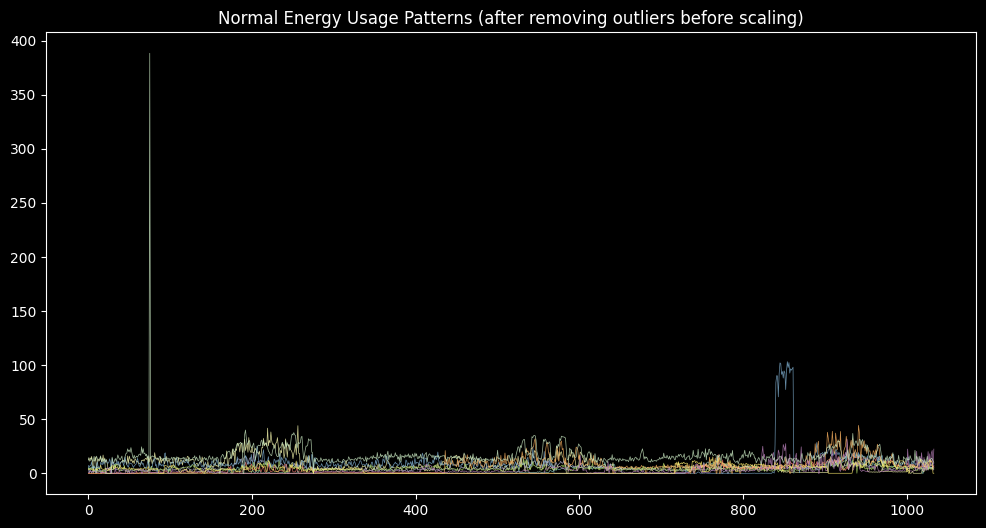

In [19]:
# Display examples of normal energy usage patterns before scaling
plt.grid()

for i in range(220, 230):
    plt.plot(range(df.shape[1]-2), df[df['FLAG']==0].iloc[i,2:], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('white') 
plt.gca().patch.set_alpha(0.9)
plt.title("Normal Energy Usage Patterns (after removing outliers before scaling)")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.gca().patch.set_facecolor('black')
plt.show()

In [20]:
# This function is used to scale the data of each customer to the range [0, 1] using MinMaxScaler method by global scaling.
def global_scaling(df):
    
    data = df[df.columns[2:]].values # get values of all columns except the first two
    
    global_min = data.min()
    global_max = data.max()
    
    # if all values are the same, standardization is not possible
    if global_max - global_min == 0:
        print("All values are the same, standardization not possible.")
        return df
    
    standardized_data = (data - global_min) / (global_max - global_min)
    
    # replace the original values with the standardized ones
    df[df.columns[2:]] = standardized_data
    
    return df

# df = global_scaling(df)

In [21]:
# This function is used to scale the data of each customer to the range [0, 1] using MinMaxScaler by each row (customer).
def row_scaling(df):
    data = df[df.columns[2:]].values  # Exclude first two columns
    row_min = data.min(axis=1, keepdims=True)
    row_max = data.max(axis=1, keepdims=True)
    denominator = row_max - row_min
    
    # if denominator is 0, set it to 1 to avoid division by zero
    denominator[denominator == 0] = 1
    
    # Standardize the data by row
    standardized_data = (data - row_min) / denominator
    
    # Replace the original values with the standardized ones
    df[df.columns[2:]] = standardized_data
    
    return df

df = row_scaling(df)

In [22]:
# Adjust the data to have 2D input 7 x N x 148 = 1036 (N = 1, 2, 3, ...)

# Get the last column's date and data
last_date = pd.to_datetime(df.columns[-1])
last_values = df.iloc[:, -1].values

# Create new dates
new_date1 = last_date + pd.Timedelta(days=1)
new_date2 = last_date + pd.Timedelta(days=2)

# Add new columns with the same values as the last column
df[new_date1.strftime('%Y/%m/%d')] = last_values
df[new_date2.strftime('%Y/%m/%d')] = last_values

# Display the updated DataFrame
df

,CONS_NO,FLAG,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,2016/11/01,2016/11/02
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.174016,0.204990,0.117875,0.188213,0.200043,0.162185,0.197032,0.144977,0.144977,0.144977
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.327142,0.282600,0.371304,0.394049,0.340220,0.365049,0.274071,0.222138,0.222138,0.222138
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.066774,0.129864,0.160949,0.076445,0.083122,0.123187,0.108911,0.084734,...,0.195026,0.140686,0.140456,0.154962,0.173152,0.250748,0.227032,0.200783,0.200783,0.200783
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.008327,0.008327,0.018925,0.020439,0.015897,0.015140,0.010598,0.025738,...,0.109765,0.160484,0.117335,0.089326,0.085541,0.101438,0.095382,0.105980,0.105980,0.105980
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.027011,0.034432,0.022262,0.038587,0.021965,0.027901,0.025230,0.035916,...,0.090828,0.117839,0.082814,0.113387,0.081627,0.087860,0.108934,0.086376,0.086376,0.086376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.081081,0.178794,0.124740,0.170478,0.135135,0.110187,0.160083,0.116424,0.116424,0.116424
42367,F1472871E1AFF49D4289564B6377D76C,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.242504,0.265432,0.263668,0.249559,0.223986,0.299824,0.316578,0.223986,0.223986,0.223986
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,0.164334,0.000000,0.000000,0.348144,0.368229,0.353621,0.186853,0.245892,...,0.189897,0.314060,0.220329,0.282410,0.225806,0.378576,0.368229,0.290323,0.290323,0.290323
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.048013,0.096026,0.076159,0.081126,0.127483,0.114238,0.073675,0.057947,...,0.053808,0.045530,0.040563,0.042219,0.065397,0.054636,0.032285,0.053808,0.053808,0.053808


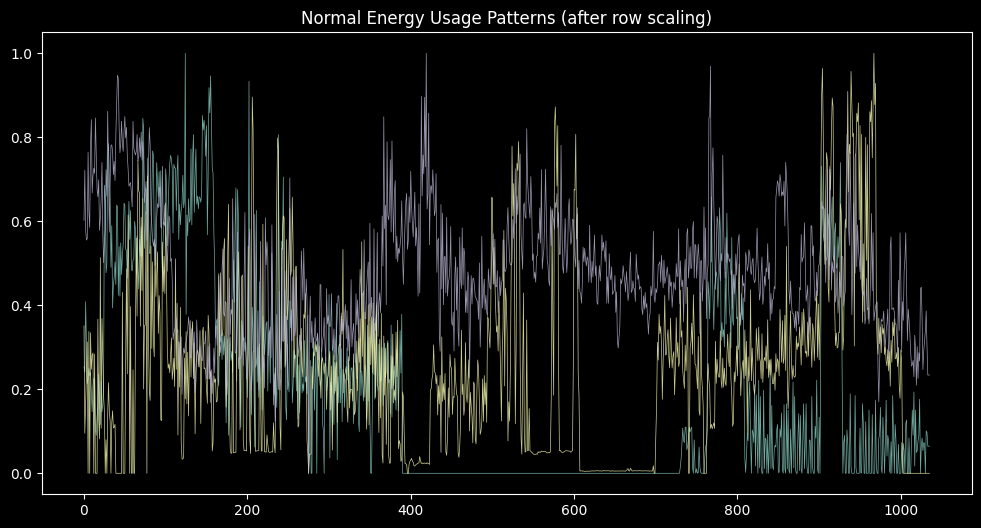

In [23]:
# Display examples of normal energy usage patterns after scaling
plt.grid()

for i in range(325, 328):
    plt.plot(range(df.shape[1]-2), df[df['FLAG']==0].iloc[i,2:], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('white') 
plt.gca().patch.set_alpha(0.9)
plt.title("Normal Energy Usage Patterns (after row scaling)")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.gca().patch.set_facecolor('black')
plt.show()

In [24]:
df

,CONS_NO,FLAG,2014/1/1,2014/1/2,2014/1/3,2014/1/4,2014/1/5,2014/1/6,2014/1/7,2014/1/8,...,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31,2016/11/01,2016/11/02
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.174016,0.204990,0.117875,0.188213,0.200043,0.162185,0.197032,0.144977,0.144977,0.144977
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.327142,0.282600,0.371304,0.394049,0.340220,0.365049,0.274071,0.222138,0.222138,0.222138
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.066774,0.129864,0.160949,0.076445,0.083122,0.123187,0.108911,0.084734,...,0.195026,0.140686,0.140456,0.154962,0.173152,0.250748,0.227032,0.200783,0.200783,0.200783
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.008327,0.008327,0.018925,0.020439,0.015897,0.015140,0.010598,0.025738,...,0.109765,0.160484,0.117335,0.089326,0.085541,0.101438,0.095382,0.105980,0.105980,0.105980
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.027011,0.034432,0.022262,0.038587,0.021965,0.027901,0.025230,0.035916,...,0.090828,0.117839,0.082814,0.113387,0.081627,0.087860,0.108934,0.086376,0.086376,0.086376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.081081,0.178794,0.124740,0.170478,0.135135,0.110187,0.160083,0.116424,0.116424,0.116424
42367,F1472871E1AFF49D4289564B6377D76C,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.242504,0.265432,0.263668,0.249559,0.223986,0.299824,0.316578,0.223986,0.223986,0.223986
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,0.164334,0.000000,0.000000,0.348144,0.368229,0.353621,0.186853,0.245892,...,0.189897,0.314060,0.220329,0.282410,0.225806,0.378576,0.368229,0.290323,0.290323,0.290323
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.048013,0.096026,0.076159,0.081126,0.127483,0.114238,0.073675,0.057947,...,0.053808,0.045530,0.040563,0.042219,0.065397,0.054636,0.032285,0.053808,0.053808,0.053808


![Alt text](image-8.png)
![Alt text](image-6.png)

In [25]:
# Data preparation
y = df['FLAG']
X = df.drop(columns=['CONS_NO', 'FLAG'])  # Drop 'CONS_NO' and 'FLAG' columns 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE-Tomek to balance the data
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Convert the data to numpy arrays
X_resampled_np = X_resampled.to_numpy()
X_test_np = X_test.to_numpy()

## (1) TCN-LSTM + DCNN Model (Provided by this paper)

In [26]:
# Hyperparameters
DAYS_PER_WINDOW = 7*4  # N weeks
TOTAL_DAYS = 1036
BATCH_SIZE = 64

num_samples = X_resampled_np.shape[0]
num_test_samples = X_test_np.shape[0]
num_windows = TOTAL_DAYS // DAYS_PER_WINDOW  

# TCN-LSTM Module
def tcn_lstm_module(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(units=32, return_sequences=True, activation='tanh')(input_layer)
    
    def residual_block(x, filters, dilation_rate):
        prev_x = x
        for i in range(2):
            x = Conv1D(filters=filters, kernel_size=5, dilation_rate=dilation_rate, padding='causal', activation='relu')(x)
        if prev_x.shape[-1] != filters:
            prev_x = Conv1D(filters=filters, kernel_size=5, padding='same')(prev_x)
        x = Add()([prev_x, x])
        return x

    x = residual_block(x, filters=32, dilation_rate=1)
    x = residual_block(x, filters=32, dilation_rate=2)
    x = residual_block(x, filters=32, dilation_rate=4)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return Model(inputs=input_layer, outputs=x)


In [27]:

# A function to define the DCNN model provided in the paper
def dcnn_module(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(input_layer)
    x = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    return Model(inputs=input_layer, outputs=x)

I0000 00:00:1722638473.184267     589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722638473.184447     589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722638473.184493     589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722638473.378689     589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722638473.378790     589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-02

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1036, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1036, 32)  │      4,352 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 37, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1036, 32)  │      5,152 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 28,    │        832 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1036, 32)  │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 28,    │     25,632 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1036, 32)  │          0 │ lstm[0][0],       │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1036, 32)  │      5,152 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 14,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1036, 32)  │      5,152 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 14,    │    102,464 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1036, 32)  │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 10, 7, 64) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1036, 32)  │      5,152 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 7,     │    204,928 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1036, 32)  │      5,152 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 7,     │    409,728 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                 

 Total params: 5,401,761 (20.61 MB)

 Trainable params: 5,401,761 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-08-02 18:41:19.069916: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1722638479.265316     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.307333     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.308785     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.310469     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.312352     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.324252     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.333571     907 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638479.340310     907 gpu_t

  2/486 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - accuracy: 0.4414 - loss: 0.9254

W0000 00:00:1722638481.692681     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.695268     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.696798     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.698248     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.700346     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.703481     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.708458     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.709865     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638481.711311     906 gp

485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7225 - loss: 0.5522

W0000 00:00:1722638530.431653     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.432755     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.434085     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.435463     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.436503     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.437515     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.438713     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.439984     906 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638530.441725     906 gp

486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7226 - loss: 0.5520

W0000 00:00:1722638531.035456     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.036910     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.039934     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.042334     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.043611     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.045241     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.048297     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.050858     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638531.053958     904 gp

486/486 ━━━━━━━━━━━━━━━━━━━━ 61s 112ms/step - accuracy: 0.7228 - loss: 0.5519 - val_accuracy: 0.8736 - val_loss: 0.3105
Epoch 2/20


W0000 00:00:1722638535.944747     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.945960     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.947192     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.948485     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.950491     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.951707     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.952933     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.954402     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722638535.955747     909 gp

486/486 ━━━━━━━━━━━━━━━━━━━━ 47s 97ms/step - accuracy: 0.8948 - loss: 0.2632 - val_accuracy: 0.9650 - val_loss: 0.1080
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9616 - loss: 0.1073 - val_accuracy: 0.9816 - val_loss: 0.0602
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9878 - loss: 0.0340 - val_accuracy: 0.9749 - val_loss: 0.0658
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9935 - loss: 0.0193 - val_accuracy: 0.9933 - val_loss: 0.0202
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.9954 - loss: 0.0138 - val_accuracy: 0.9964 - val_loss: 0.0105
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 54s 111ms/step - accuracy: 0.9971 - loss: 0.0077 - val_accuracy: 0.9705 - val_loss: 0.0805
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 53s 108ms/step - accuracy: 0.9960 - loss: 0.0113 - val_accuracy: 0.9970 - val_loss: 0.0069
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9980 - loss: 0.0072 - val_

W0000 00:00:1722639503.701063     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.718910     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.726753     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.727321     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.729982     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.730336     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.732346     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.732694     909 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.733893     908 gp

  3/167 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step   

W0000 00:00:1722639503.904213     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.906801     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.908556     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.910216     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.911641     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.913061     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.914574     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.915983     908 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639503.917510     908 gp

166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

W0000 00:00:1722639509.827808     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.829405     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.830817     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.832714     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.833901     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.834954     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.835971     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.836904     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639509.837805     904 gp

167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


W0000 00:00:1722639510.029216     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.030528     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.031791     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.033181     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.034986     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.041887     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.043213     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.044270     904 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722639510.045502     904 gp

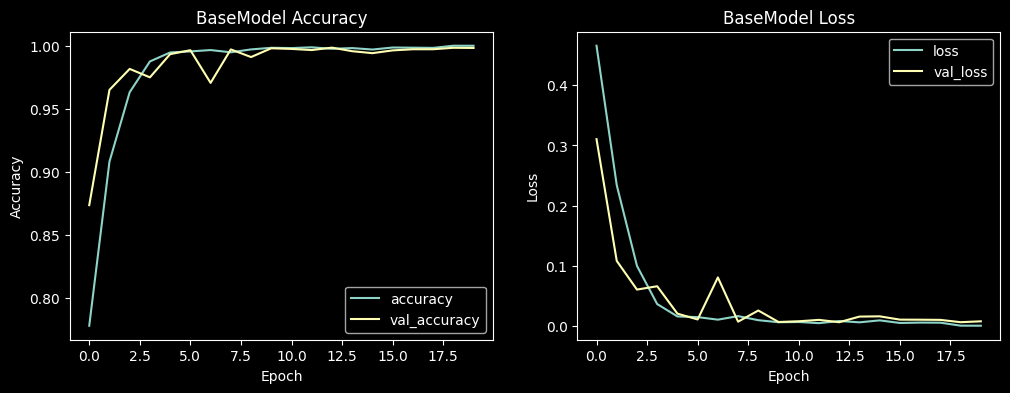

              precision    recall  f1-score   support

           0     0.9425    0.9721    0.9570      4869
           1     0.5390    0.3549    0.4280       448

    accuracy                         0.9201      5317
   macro avg     0.7407    0.6635    0.6925      5317
weighted avg     0.9085    0.9201    0.9125      5317



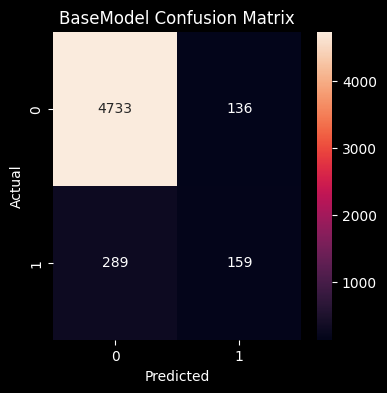

In [28]:
# Data preparation for TCN-LSTM
X_resampled_tcn = X_resampled_np.reshape((num_samples, TOTAL_DAYS, 1))  # For TCN-LSTM
X_test_tcn = X_test_np.reshape((num_test_samples, TOTAL_DAYS, 1))

# Data preparation for DCNN
X_resampled_dcnn = X_resampled_np.reshape((num_samples, num_windows, DAYS_PER_WINDOW, 1))
X_test_dcnn = X_test_np.reshape((num_test_samples, num_windows, DAYS_PER_WINDOW, 1))

# Define the TCN-LSTM and DCNN models
tcn_lstm_model = tcn_lstm_module((TOTAL_DAYS, 1))
dcnn_model = dcnn_module((num_windows, DAYS_PER_WINDOW, 1))

# Feature Fusion Module
tcn_output = tcn_lstm_model.output
dcnn_output = dcnn_model.output

merged_output = concatenate([tcn_output, dcnn_output])
output_layer = Dense(1, activation='sigmoid')(merged_output)

# Base Model (TCN-LSTM + DCNN)
base_model = Model(inputs=[tcn_lstm_model.input, dcnn_model.input], outputs=output_layer)
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
base_model.summary()

# Training the model
history = base_model.fit([X_resampled_tcn, X_resampled_dcnn], y_resampled, epochs=20, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

# Generate predictions
y_pred_base = base_model.predict([X_test_tcn, X_test_dcnn])
y_pred_base = (y_pred_base > 0.5).astype(int)

plt.figure(figsize=(12, 4))

# Plot the training history
plt.subplot(1, 2, 1)
plt.title("BaseModel Accuracy")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training history
plt.subplot(1, 2, 2)
plt.title("BaseModel Loss")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_base, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(4, 4))
plt.title("BaseModel Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## (2) Multi-head Attention + DCNN Model (Improved Model)

In [28]:
# Hyperparameters
NUM_HEAD = 4
NUM_LAYER = 1
NUM_DIM = 32
DAYS_PER_WINDOW = 7*2  # N weeks 
# TOTAL_DAYS = 1029
TOTAL_DAYS = 1036
BATCH_SIZE = 64

# A function to define the attention model: position encoding, multi-head attention, and global pooling
def attention_module(input_shape, num_heads, num_attention_layers, num_dims):
    input_layer = Input(shape=input_shape)
    
    # Position Encoding
    position_indices = tf.range(start=0, limit=input_shape[0], delta=1)
    position_encoding = Embedding(input_dim=input_shape[0], output_dim=num_dims)(position_indices)
    position_encoding = Lambda(lambda x: tf.expand_dims(x, axis=0))(position_encoding)  
    
    # Expand input layer and tile to match num_dims
    input_layer_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_layer)
    input_layer_expanded = Lambda(lambda x: tf.tile(x, [1, 1, num_dims]))(input_layer_expanded)
    
    x = input_layer_expanded + position_encoding  # Broadcasting 가능
    
    # Initial Residual Connection
    initial_input = x
    
    # Add multiple attention layers based on the num_attention_layers input
    for _ in range(num_attention_layers):
        # Multi-Head Attention Layer
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=num_dims)(x, x)
        attn_output = LayerNormalization(epsilon=1e-5)(attn_output)
        
        # Residual Connection
        x = Add()([attn_output, x])
        
    x = Add()([x, initial_input])
    
    # Global Pooling for reducing dimensionality
    x = GlobalAveragePooling1D()(x)
    
    # Final Dense Layer
    x = Dense(128, activation='relu')(x)
    
    return Model(inputs=input_layer, outputs=x)

# Reshape the data for DCNN as 4D tensor
num_samples = X_resampled_np.shape[0]
num_windows = TOTAL_DAYS // DAYS_PER_WINDOW  
X_resampled_dcnn = X_resampled_np.reshape((num_samples, num_windows, DAYS_PER_WINDOW, 1))

num_test_samples = X_test_np.shape[0]
X_test_dcnn = X_test_np.reshape((num_test_samples, num_windows, DAYS_PER_WINDOW, 1))

# Data preparation as 1D tensor for LSTM and Attention models
X_resampled_attn = X_resampled_np
X_test_attn = X_test_np

# Instantiate the attention model with the input shape, number of heads, number of attention layers, and number of dimensions
attention_model = attention_module((X_resampled_attn.shape[1],), num_heads=NUM_HEAD, num_attention_layers=NUM_LAYER, num_dims=NUM_DIM)

# Define the DCNN model with the input shape
dcnn_model = dcnn_module((num_windows, DAYS_PER_WINDOW, 1))

# Advanced Feature Fusion Module
attn_output = attention_model.output
dcnn_output = dcnn_model.output
merged = concatenate([attn_output, dcnn_output])
output_layer = Dense(1, activation='sigmoid')(merged)

final_model = Model(inputs=[attention_model.input, dcnn_model.input], outputs=output_layer)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 74, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1036)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 74, 14,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1036, 1)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 7, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1036, 32)  │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 7, 64) │     18,496 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1036, 32)  │          0 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 7, 64) │     36,928 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1036, 32)  │     16,800 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 19, 4, 64) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1036, 32)  │         64 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 19, 4,     │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1036, 32)  │          0 │ layer_normalizat… │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 19, 4,     │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 1036, 32)  │          0 │ add_4[0][0],      │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 2,     │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 635,585 (2.42 MB)

 Trainable params: 635,585 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1722278514.094719   13808 service.cc:146] XLA service 0x7fc4f80079a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722278514.095012   13808 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-07-29 14:41:54.252023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-29 14:41:54.825469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1722278517.108801   13808 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722278517.326644   13808 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/486 ━━━━━━━━━━━━━━━━━━━━ 1:47:55 13s/step - accuracy: 0.3750 - loss: 0.9528

I0000 00:00:1722278523.902583   13808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7153 - loss: 0.5581

E0000 00:00:1722278572.455853   13806 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722278572.667978   13806 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722278572.885770   13806 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722278573.209536   13806 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-07-29 14:42:53.266787: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[41,32,74,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[41,32,74,14]{3,2,1,0}, 

486/486 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.7156 - loss: 0.5577 - val_accuracy: 0.8283 - val_loss: 0.3730
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.8494 - loss: 0.3579 - val_accuracy: 0.7703 - val_loss: 0.4644
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.8918 - loss: 0.2637 - val_accuracy: 0.9234 - val_loss: 0.1928
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 52s 107ms/step - accuracy: 0.9148 - loss: 0.2146 - val_accuracy: 0.9584 - val_loss: 0.1171
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.9322 - loss: 0.1730 - val_accuracy: 0.9676 - val_loss: 0.0988
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.9573 - loss: 0.1174 - val_accuracy: 0.9857 - val_loss: 0.0485
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.9679 - loss: 0.0859 - val_accuracy: 0.9821 - val_loss: 0.0477
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.9794 - loss: 0.0565 - val

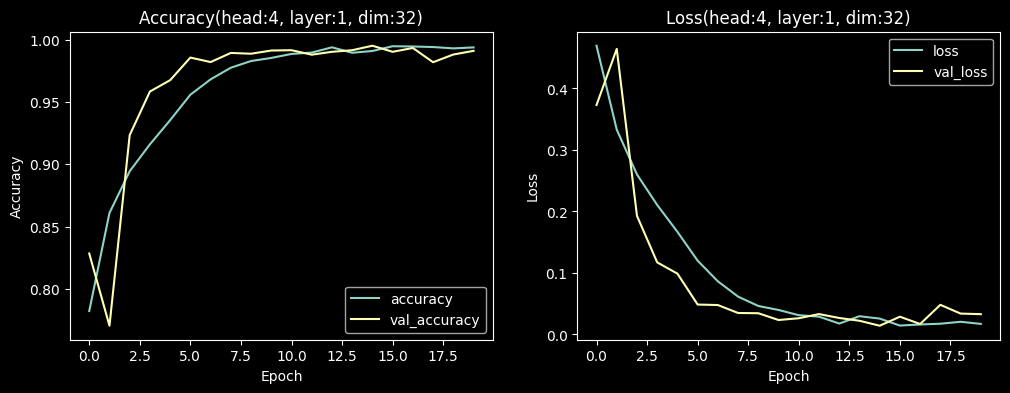

              precision    recall  f1-score   support

           0     0.9450    0.9675    0.9562      4869
           1     0.5241    0.3884    0.4462       448

    accuracy                         0.9188      5317
   macro avg     0.7346    0.6780    0.7012      5317
weighted avg     0.9096    0.9188    0.9132      5317



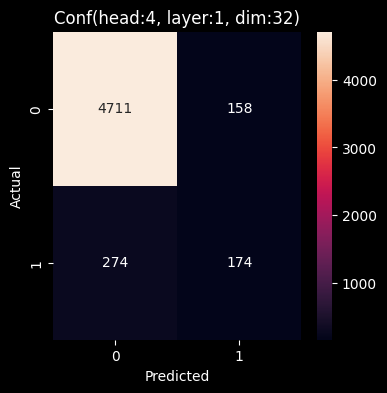

In [29]:
# Train the model
history = final_model.fit([X_resampled_attn, X_resampled_dcnn], y_resampled, epochs=20, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

# Generate predictions
y_pred_final = final_model.predict([X_test_attn, X_test_dcnn])
y_pred_final = (y_pred_final > 0.5).astype(int)

plt.figure(figsize=(12, 4))

# Plot the training history
plt.subplot(1, 2, 1)
plt.title("Accuracy(head:{}, layer:{}, dim:{})" .format(NUM_HEAD, NUM_LAYER, NUM_DIM))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training history
plt.subplot(1, 2, 2)
plt.title("Loss(head:{}, layer:{}, dim:{})" .format(NUM_HEAD, NUM_LAYER, NUM_DIM))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_final, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(4, 4))
plt.title("Conf(head:{}, layer:{}, dim:{})" .format(NUM_HEAD, NUM_LAYER, NUM_DIM))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# history2 = final_model.fit([X_resampled_attn, X_resampled_dcnn], y_resampled, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# # append history2 to history 
# history.history['accuracy'] += history2.history['accuracy']
# history.history['val_accuracy'] += history2.history['val_accuracy']
# history.history['loss'] += history2.history['loss']
# history.history['val_loss'] += history2.history['val_loss']


In [ ]:
# 모델 저장
# final_model.save('final_model_attention.h5')


## (3) Vision Transformers 

In [26]:
# Assume each sample has 1036 time steps
sequence_length = X_resampled_np.shape[1]
patch_size = 28  # You can change this according to the sequence length
num_patches = sequence_length // patch_size

# Reshape data into patches
X_resampled_patches = X_resampled_np.reshape(-1, num_patches, patch_size)
X_test_patches = X_test_np.reshape(-1, num_patches, patch_size)

# Vision Transformer (ViT) Model
def create_vit_model(input_shape, num_patches, d_model, num_heads, num_layers, mlp_head_units, num_classes):
    inputs = keras.Input(shape=input_shape)
    patches = layers.Reshape((num_patches, -1))(inputs)
    
    # Linear Projection of Patches
    patch_embedding = layers.Dense(d_model)(patches)
    
    # Adding positional embedding
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=d_model)(tf.range(num_patches))
    embedded_patches = patch_embedding + position_embedding
    
    # Transformer Encoder
    for _ in range(num_layers):
        x = layers.LayerNormalization(epsilon=1e-6)(embedded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.Add()([attention_output, embedded_patches])
        
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn = keras.Sequential([
            layers.Dense(d_model * 4, activation='relu'),
            layers.Dense(d_model),
        ])
        x = layers.Add()([ffn(x), x])
        embedded_patches = x
    
    # Final MLP head for classification
    x = layers.LayerNormalization(epsilon=1e-6)(embedded_patches)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_head_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
input_shape = X_resampled_patches.shape[1:]
d_model = 64
num_heads = 8
num_layers = 5
mlp_head_units = [128, 64]
num_classes = 2  # Adjust according to the number of classes (binary classification)
num_patches = X_resampled_patches.shape[1]

# Model creation and compilation
vit_model = create_vit_model(input_shape, num_patches, d_model, num_heads, num_layers, mlp_head_units, num_classes)
vit_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

vit_model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')]

# Model training
history = vit_model.fit(
    X_resampled_patches,
    y_resampled,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks
)


I0000 00:00:1722400195.947759   18846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722400195.947927   18846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722400195.947971   18846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722400196.190083   18846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722400196.190180   18846 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 37, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 37, 28)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 37, 64)    │      1,856 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 37, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 37, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 64)    │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 37, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 37, 64)    │     33,088 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 37, 64)    │          0 │ sequential[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 64)    │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 37, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 37, 64)    │     33,088 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 37, 64)    │          0 │ sequential_1[0][… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 64)    │    132,672 │ layer_normalizat

 Total params: 848,770 (3.24 MB)

 Trainable params: 848,770 (3.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1722400208.625968   18926 service.cc:146] XLA service 0x7fd80c00f0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722400208.626133   18926 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-07-31 00:30:08.918169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 00:30:10.214722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-31 00:30:20.546268: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 80 bytes spill stores, 80 bytes spill loads

I0000 00:00:1722400220.615332   18926 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6365 - loss: 0.6441

2024-07-31 00:30:40.453118: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 80 bytes spill stores, 80 bytes spill loads



486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.6367 - loss: 0.6438 - val_accuracy: 0.8161 - val_loss: 0.5074
Epoch 2/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7719 - loss: 0.5017 - val_accuracy: 0.6568 - val_loss: 0.5640
Epoch 3/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8129 - loss: 0.4377 - val_accuracy: 0.7340 - val_loss: 0.4996
Epoch 4/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8277 - loss: 0.4052 - val_accuracy: 0.8474 - val_loss: 0.3164
Epoch 5/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8334 - loss: 0.3876 - val_accuracy: 0.8816 - val_loss: 0.2656
Epoch 6/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8476 - loss: 0.3608 - val_accuracy: 0.8002 - val_loss: 0.4091
Epoch 7/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8645 - loss: 0.3346 - val_accuracy: 0.8749 - val_loss: 0.2855
Epoch 8/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8691 - loss: 0.3200 - val_acc

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


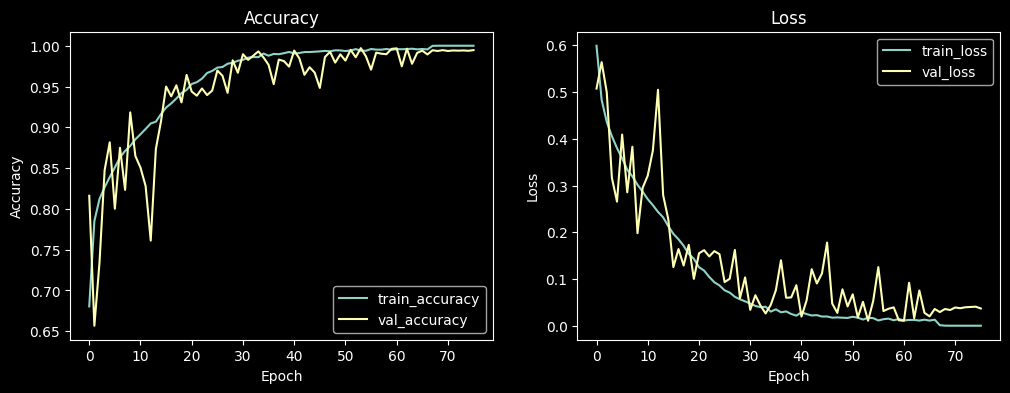

              precision    recall  f1-score   support

           0     0.9495    0.8885    0.9180      4869
           1     0.2865    0.4866    0.3606       448

    accuracy                         0.8546      5317
   macro avg     0.6180    0.6875    0.6393      5317
weighted avg     0.8936    0.8546    0.8710      5317



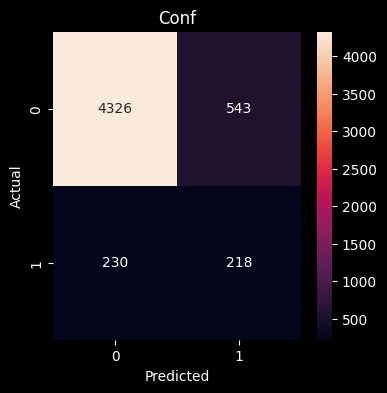

In [28]:
y_pred_vit = vit_model.predict(X_test_patches)
y_pred_vit = np.argmax(y_pred_vit, axis=1)


plt.figure(figsize=(12, 4))

# Plot the training history
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training history
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_vit, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_vit)
plt.figure(figsize=(4, 4))
plt.title("Conf")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## (4) Swin Transformers

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Data preparation
y = df['FLAG']
X = df.drop(columns=['CONS_NO', 'FLAG'])  # Drop 'CONS_NO' and 'FLAG' columns 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE-Tomek to balance the data
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Convert the data to numpy arrays
X_resampled_np = X_resampled.to_numpy()
X_test_np = X_test.to_numpy()

# Assume each sample has 1036 time steps
sequence_length = X_resampled_np.shape[1]
patch_size = 28
num_patches = sequence_length // patch_size

# Reshape data into patches
X_resampled_patches = X_resampled_np.reshape(-1, num_patches, patch_size)
X_test_patches = X_test_np.reshape(-1, num_patches, patch_size)

# Swin Transformer block
def swin_transformer_block(x, num_heads, head_dim, window_size, shift_size):
    # Create windowed embeddings
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Conv1D(filters=head_dim*num_heads, kernel_size=1)(x)
    # Local self-attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_dim)(x, x)
    x = layers.Dropout(0.3)(x)
    return x

def create_swin_model(input_shape, num_patches, d_model, num_heads, num_layers, mlp_head_units, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Reshape((num_patches, -1))(inputs)
    
    # Embedding
    x = layers.Dense(d_model)(x)
    
    # Swin Transformer Blocks
    for _ in range(num_layers):
        x = swin_transformer_block(x, num_heads, head_dim=d_model//num_heads, window_size=4, shift_size=2)
    
    # MLP Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_head_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
input_shape = X_resampled_patches.shape[1:]
d_model = 128
num_heads = 8
num_layers = 4
mlp_head_units = [128, 64]
num_classes = 2  # Adjust according to the number of classes (binary classification)
num_patches = X_resampled_patches.shape[1]

# Model creation and compilation
swin_model = create_swin_model(input_shape, num_patches, d_model, num_heads, num_layers, mlp_head_units, num_classes)
swin_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.00007),
    metrics=['accuracy']
)

swin_model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor='val_accuracy')]

# Model training
history = swin_model.fit(
    X_resampled_patches,
    y_resampled,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks
)

# Model evaluation
swin_model.evaluate(X_test_patches, y_test, verbose=1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 37, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 37, 28)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 37, 128)   │      3,712 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ dense_8[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 37, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ conv1d_8[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 37, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ dropout_21[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 37, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ conv1d_9[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 37, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ dropout_23[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 37, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ conv1d_10[0][0],  │
│ (MultiHeadAttentio… │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 37, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 128)   │        256 │ dropout_25[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 37, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 37, 128)   │     66,048 │ conv1d_11[0][0],  │
│ (MultiHeadAttentio… │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 37, 128)   │          0 │ multi_head_atten

 Total params: 360,130 (1.37 MB)

 Trainable params: 360,130 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.6076 - loss: 0.6758 - val_accuracy: 0.0000e+00 - val_loss: 1.0320
Epoch 2/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6269 - loss: 0.6646 - val_accuracy: 0.0000e+00 - val_loss: 0.9643
Epoch 3/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6219 - loss: 0.6600 - val_accuracy: 0.0661 - val_loss: 1.0058
Epoch 4/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7393 - loss: 0.5437 - val_accuracy: 0.7946 - val_loss: 0.4609
Epoch 5/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7821 - loss: 0.4790 - val_accuracy: 0.7452 - val_loss: 0.6124
Epoch 6/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7986 - loss: 0.4514 - val_accuracy: 0.6940 - val_loss: 0.7091
Epoch 7/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8139 - loss: 0.4251 - val_accuracy: 0.7802 - val_loss: 0.4841
Epoch 8/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8253 - loss: 

[1.161109209060669, 0.8036486506462097]

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


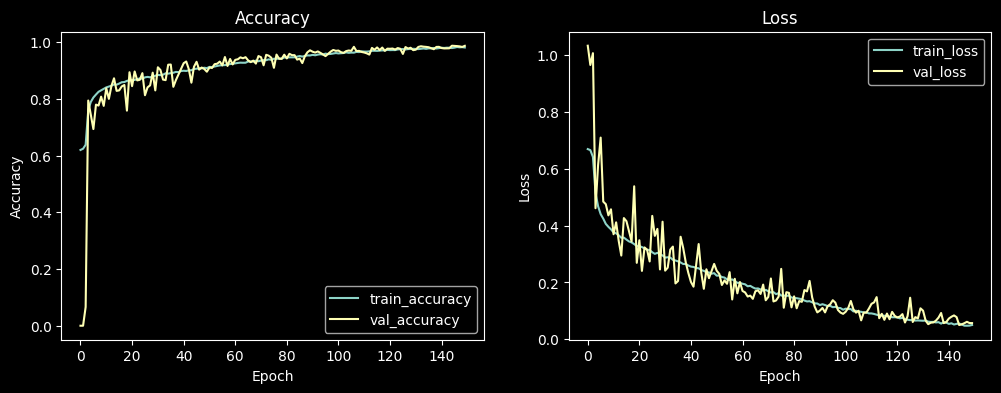

              precision    recall  f1-score   support

           0     0.9463    0.8328    0.8860      4869
           1     0.2112    0.4866    0.2946       448

    accuracy                         0.8036      5317
   macro avg     0.5788    0.6597    0.5903      5317
weighted avg     0.8844    0.8036    0.8361      5317



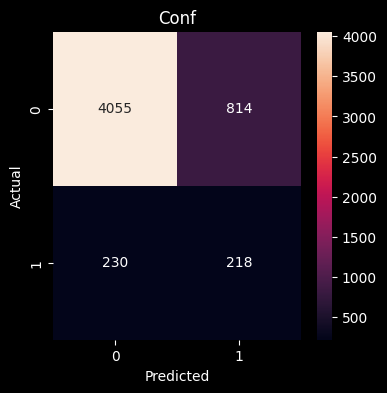

In [32]:
y_pred_swin = swin_model.predict(X_test_patches)
y_pred_swin = np.argmax(y_pred_swin, axis=1)


plt.figure(figsize=(12, 4))

# Plot the training history
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training history
plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification report
print(classification_report(y_test, y_pred_swin, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_swin)
plt.figure(figsize=(4, 4))
plt.title("Conf")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## (5) CvT: Convloutional Vision Transformer

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Data preparation
y = df['FLAG']
X = df.drop(columns=['CONS_NO', 'FLAG'])  # Drop 'CONS_NO' and 'FLAG' columns 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE-Tomek to balance the data
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Convert the data to numpy arrays
X_resampled_np = X_resampled.to_numpy()
X_test_np = X_test.to_numpy()

# Assume each sample has 1036 time steps
sequence_length = X_resampled_np.shape[1]

# Reshape data for model input
X_resampled_np = X_resampled_np.reshape(-1, sequence_length, 1)
X_test_np = X_test_np.reshape(-1, sequence_length, 1)

# CvT Model
def conv_transformer_block(inputs, filters, num_heads, projection_dim, num_transformer_layers):
    x = layers.Conv1D(filters=filters, kernel_size=3, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Activation("relu")(x)
    
    for _ in range(num_transformer_layers):
        # Multi-Head Attention Layer
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
        attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)
        attn_output = layers.Dropout(0.1)(attn_output)
        
        # Add and Normalize
        x = layers.Add()([attn_output, x])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed Forward Network
        ffn = keras.Sequential([
            layers.Dense(projection_dim, activation="relu"),
            layers.Dense(filters),
        ])
        x = ffn(x)
        x = layers.Dropout(0.1)(x)
        
        # Add and Normalize
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
    return x

def create_cvt_model(input_shape, filters, num_heads, projection_dim, num_transformer_layers, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Convolutional Block
    x = layers.Conv1D(filters=filters, kernel_size=3, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Transformer Block
    x = conv_transformer_block(x, filters, num_heads, projection_dim, num_transformer_layers)
    
    # Flatten and Dense Layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    return model

# Parameters
input_shape = X_resampled_np.shape[1:]
filters = 64
num_heads = 4
projection_dim = 64
num_transformer_layers = 2
num_classes = 2  # Adjust according to the number of classes (binary classification)

# Model creation and compilation
cvt_model = create_cvt_model(input_shape, filters, num_heads, projection_dim, num_transformer_layers, num_classes)
cvt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

cvt_model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')]

# Model training
history = cvt_model.fit(
    X_resampled_np,
    y_resampled,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks
)

# Model evaluation
cvt_model.evaluate(X_test_np, y_test, verbose=1)


I0000 00:00:1722723618.642512     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723618.643061     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723618.643684     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723618.887680     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722723618.887785     752 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1036, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1036, 64)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1036, 64)  │        128 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1036, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 518, 64)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 518, 64)   │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 518, 64)   │        128 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 518, 64)   │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 518, 64)   │     66,368 │ activation_1[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 518, 64)   │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 518, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 518, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 518, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 518, 64)   │      8,320 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 518, 64)   │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 518, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 518, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 518, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 171,586 (670.26 KB)

 Trainable params: 171,586 (670.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1722723626.171599    1288 service.cc:146] XLA service 0x7f7498001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722723626.171665    1288 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-08-03 18:20:26.386105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-03 18:20:27.305343: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/486 ━━━━━━━━━━━━━━━━━━━━ 2:16:23 17s/step - accuracy: 0.4688 - loss: 0.8707

I0000 00:00:1722723636.332562    1288 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 ━━━━━━━━━━━━━━━━━━━━ 79s 129ms/step - accuracy: 0.6866 - loss: 0.5930 - val_accuracy: 0.8035 - val_loss: 0.4022
Epoch 2/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 48s 99ms/step - accuracy: 0.8119 - loss: 0.4354 - val_accuracy: 0.7846 - val_loss: 0.4677
Epoch 3/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.8259 - loss: 0.4079 - val_accuracy: 0.8546 - val_loss: 0.3049
Epoch 4/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.8405 - loss: 0.3817 - val_accuracy: 0.8321 - val_loss: 0.3548
Epoch 5/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.8427 - loss: 0.3738 - val_accuracy: 0.8148 - val_loss: 0.3923
Epoch 6/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.8533 - loss: 0.3515 - val_accuracy: 0.8502 - val_loss: 0.3174
Epoch 7/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.8619 - loss: 0.3350 - val_accuracy: 0.8310 - val_loss: 0.3712
Epoch 8/150
486/486 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.8707 - loss: 0.3173

[0.48890599608421326, 0.7844648957252502]